In [6]:
import json
import joblib
import keras

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import preprocessing as pp


## Load and preprocess data 

In [7]:
with open(f"C:/Users/ltuesta/Desktop/Files/Dev/local_python/data/data_bands.json", 'r') as f:
    train_data = json.load(f)
with open(f"C:/Users/ltuesta/Desktop/Files/Dev/local_python/data/data_test_bands.json", 'r') as f:
    test_data = json.load(f)

X_train, X_train_flat, y_train, c_train = pp.normalize_parcelles(train_data)
X_test, X_test_flat, y_test, c_test = pp.normalize_parcelles(test_data)

c_train_binary = to_categorical(c_train, num_classes=11)
c_test_binary = to_categorical(c_test, num_classes=11)

## Display 

In [15]:
def display_hist(history):
    fig, axs = plt.subplots(2, figsize=(10,12))
    #plot training history - accuracy
    axs[0].plot(history.history['accuracy'], label='train')
    axs[0].plot(history.history['val_accuracy'], label='validation')
    axs[0].set_title("Accuracy at each epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    
    #plot training history - loss function
    axs[1].plot(history.history['loss'], label='train')
    axs[1].plot(history.history['val_loss'], label='validation')
    axs[1].legend()
    axs[1].set_title("Loss at each epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("categorical_crossentropy")
    plt.show()

In [16]:
target_names = ['Autres céréales _ Plante à fibre _ Riz','Blé tendre','Maïs grain et ensilage','Orge','Protéagineux _ leguminause à grain',
                'Colza','Tournesol','Autres oléagineux',
                'Fourrage_Estives et landes_Prairies permanentes_Prairies temporaires','Vergers_Vignes_Fruits à coque_Oliviers',
                'Autres cultures industrielles_Légumes ou fleurs']

In [17]:
def plot_confusion_matrix_perso(cm, target_names, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    corr_mat_filtre = np.where(cm >= 0.05, cm, np.nan)
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr_mat_filtre, annot=True, cmap="coolwarm", vmin=0.0, xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


## Dense

In [18]:
def construct_model() -> keras.src.models.sequential.Sequential:
    """building the model skeleton

    Returns:
        keras.src.models.sequential.Sequential: model
    """
    model_dense = tf.keras.Sequential([
        tf.keras.Input((312, )),
        Dense(312),
        Dense(156),
        Dropout(0.1),
        Dense(78),
        Dropout(0.1),
        Dense(39),
        Dense(11, activation=tf.nn.softmax)
    ])
    
    model_dense.summary()

    return model_dense

In [19]:
def train_dense_model(model:keras.src.models.sequential.Sequential, X_train: list, y_train: list, X_val: list, y_val: list)-> keras.src.models.sequential.Sequential:
    """train the model

    Args:
        model (keras.src.models.sequential.Sequential): model
        X_train (list): X data for training
        y_train (list): y data for training
        X_val (list): X data for validation
        y_val (list): y data for validation

    Returns:
        keras.src.models.sequential.Sequential: model train
    """
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    callback = EarlyStopping(min_delta=1e-5, 
                             patience = 50, 
                             mode = "max", 
                             monitor = "val_accuracy", 
                             restore_best_weights=True)
    history_dense = model.fit(
        np.array(X_train),
        np.array(y_train),
        batch_size=512,
        epochs=300,
        validation_data=(np.array(X_val), np.array(y_val)),
        callbacks = [callback]
    )

    display_hist(history_dense)

    return model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 312)                 │          97,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 156)                 │          48,828 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 156)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 78)                  │          12,246 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 78)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 39)                  │           3,081 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 11)                  │             440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,251 (633.79 KB)

 Trainable params: 162,251 (633.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3070 - loss: 7487.7710 - val_accuracy: 0.5915 - val_loss: 967.7679
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5441 - loss: 779.4330 - val_accuracy: 0.6940 - val_loss: 262.9034
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6414 - loss: 315.4979 - val_accuracy: 0.7453 - val_loss: 174.2879
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6526 - loss: 250.7182 - val_accuracy: 0.7400 - val_loss: 147.0057
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6779 - loss: 206.6805 - val_accuracy: 0.7667 - val_loss: 112.7053
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6826 - loss: 182.3617 - val_accuracy: 0.7515 - val_loss: 109.4720
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6795 - loss: 174.9125 - val_accuracy: 0.7825 - val_loss: 95.9456
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7001 - los

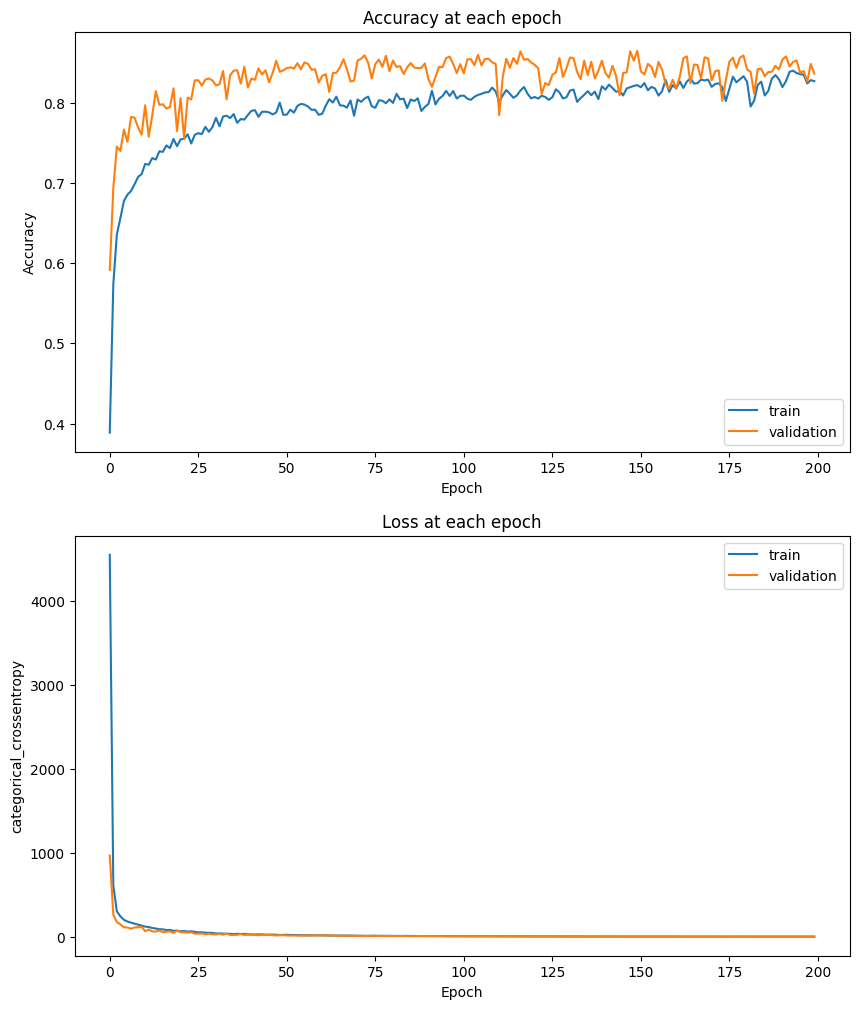

In [21]:
dense_model = construct_model()
dense_model = train_dense_model(dense_model, X_train_flat, c_train_binary, X_test_flat, c_test_binary)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


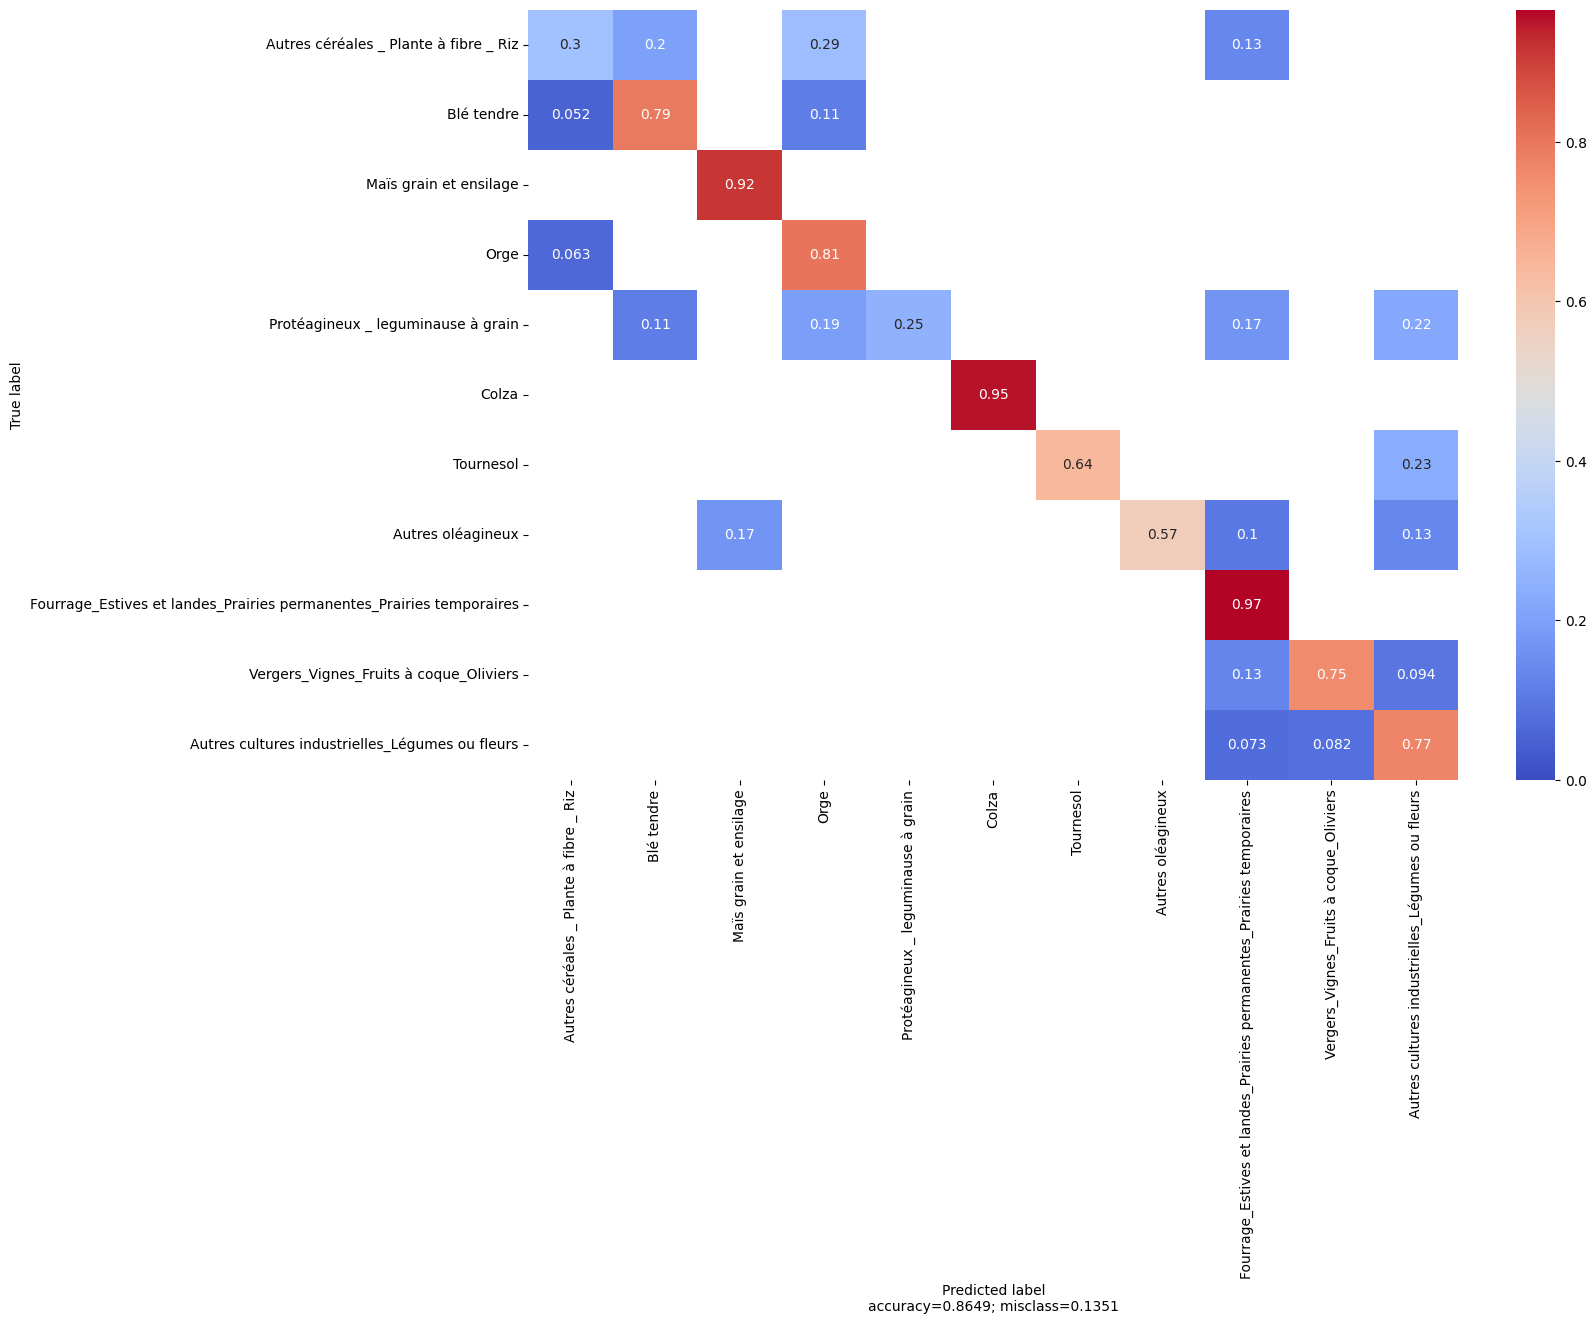

In [23]:
dense_prediction = np.argmax(dense_model.predict(np.array(X_test_flat)), axis=1) 
conf_matrix_dense = confusion_matrix(c_test, dense_prediction)
plot_confusion_matrix_perso(conf_matrix_dense, target_names, title='Confusion matrix')

In [24]:
dense_model.save('models/multicrop_classification.h5')